# 2 Microscopic Traffic Simulation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import traci
import time

## 2.1 Model building and generate random vehicle input  


First, we need to generate random vehicle arrival that follows the poisson process. In this case, the arrival times are directly representing the time that the vehicle is loaded on the road. We assume that the arrival rate of vehicles is 3000/3600, meaning that there will be 3000 vehicles loading on the road in one hour. 
<!-- And we use the method that mentioned in th Sheldon M. Ross's simulation book to decide when to stop generate new vehicle. -->

[0.3522169859567281, 0.34143732399373383, 0.6906700534993978, 0.9385476927283414, 0.7390289536043775, 0.014928475052877286, 0.02038887432742532, 1.8456593110389377, 1.6268199242092858, 1.5231074055651652, 0.8404834649007239, 0.03608664460990531, 0.282304427069414, 0.3866189032178969, 4.732869172756258, 0.22435681843573102, 1.4337675368681053, 1.4276864368899964, 0.24457430958339557, 0.07172426515139503, 2.4152331225693566, 1.7618429821168369, 3.076233746041268, 0.28164685949185464, 4.595608131964139, 0.6732233174398567, 1.719925906456573, 0.6167401706572788, 1.0800548495664763, 1.8402877328963068, 0.5648977552815562, 0.9973445654633638, 0.03380705546408736, 1.422987587673785, 1.2652095610969334, 1.3359793197373258, 0.04036430764006635, 0.23413010356541955, 0.38402291252916687, 1.3827258284100834, 0.17312219089927094, 1.5446163019111874, 1.1417520628727238, 1.6006904262193913, 0.9043930723283413, 4.0447189540808175, 0.48050534731611433, 1.7529725375502863, 0.617705220433335, 0.278058254

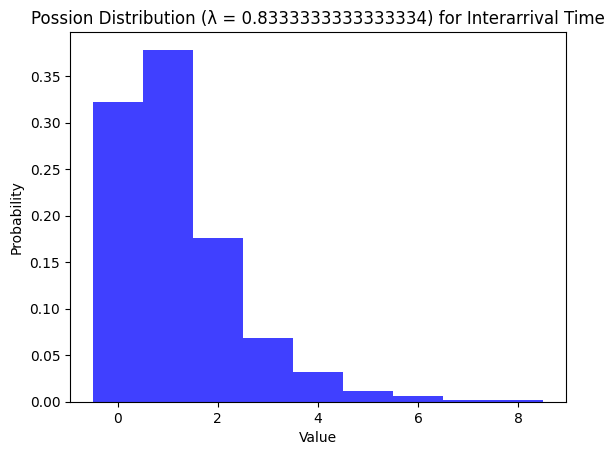

In [11]:
def generate_interarrival_time(lamda):
  start_time=0
  t = start_time

  u1 = np.random.random()
  t -= np.log(u1) / lamda
  
  return t

arrival_rate = 3000/3600  # Arrival rate of 3000 vehicles per hour


# Plot the histogram of multiple generated arrival time random variables
random_variable_size = 3000
interarrival_times = [generate_interarrival_time(arrival_rate) for _ in range(random_variable_size)]

print(interarrival_times)

# Plot the histogram of generated arrival time random variables
plt.hist(interarrival_times, bins=np.arange(min(interarrival_times), max(interarrival_times) + 1) - 0.5, density=True, alpha=0.75, color='b')
plt.title(f'Possion Distribution (λ = {arrival_rate}) for Interarrival Time')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.show()

After generating the vehicles by python, we write them to the xml file called AH2174_2023_project1_section2.rou.xml. All these vehicles will go through from edge 1 to edge 5. We assume there are two types of vehicle. One is 'Car', its acceleration is 2.5 m/s2, its deceleration is 5m/s2, and its vehicle legnth is 5 meters. Another one is 'Bus', its accelaration is 1.5 m/s2, its deceleration is 4 m/s2, and it vehicle length is 18 meters. And we assign the vehicle type randomly to each vehicle. But considering that normally there will be more cars on the road, so we assume a vehicle 70 percent probability to be a car.  

In [7]:
def vehicle2file():
    # Write arrivals to a file (e.g., sumo_test.arr.xml)
    with open('AH2174_2023_project1_section2.rou.xml', 'w') as f:
        f.write('<routes>\n')
        f.write('<vType accel="2.5" decel="5.0" id="Car" length="5.0" maxSpeed="40" sigma="1.0" carFollowModel="IDM"/>\n')
        f.write('<vType accel="1.5" decel="4.0" id="Bus" length="18.0" maxSpeed="25" sigma="1.0" carFollowModel="IDM" />\n')
        f.write('<route id="r1" edges="edge1 edge2 edge3 edge4 edge5"/>\n')

        depart_time=0 
        for num_vehicles,time in enumerate(interarrival_times):
            # the next arrival time is calculated by the last arrival time plus their interarrival time
            depart_time+=time

            vehicle_type = np.random.choice(['Car', 'Bus'], size=1,p=[0.7, 0.3])[0]
            f.write(f'<vehicle depart="{depart_time}" route="r1" id="{num_vehicles}" type="{vehicle_type}"/>\n')
        f.write('</routes>')

To check the number of vehicles loaded on the specific highway section in a SUMO simulation, we can use the traci module, which is the interface for interacting with a running SUMO simulation.  We need to query the vehicles that are currently present on the edges representing the highway section of interest.

In [64]:
traci.close()

In [65]:
# Start the SUMO simulation with your configuration file (e.g., sumo_test.sumocfg)
traci.start(["sumo", "-c", "AH2174_2023_project1_section2.sumo.cfg"])

# Run the simulation for a certain number of steps
i=1
simulation_steps = 1000

# Define the edges representing the highway section (e.g., edge1, edge2, etc.)
highway_edges = ["edge1", "edge2", "edge3", "edge4", "edge5"]
for _ in range(simulation_steps):
    traci.simulationStep()
    IDList = traci.vehicle.getIDList()
    # print the vehicle info when not empty
    if len(IDList):
        # Get the list of currently loaded vehicles on the highway section
        loaded_vehicles_on_highway = [v for v in IDList if traci.vehicle.getRoadID(v) in highway_edges]
        # Get the number of loaded vehicles on the highway section
        num_loaded_vehicles_on_highway = len(loaded_vehicles_on_highway)  
        print(i, IDList)
        print(f'Number of loaded vehicles on the highway section: {num_loaded_vehicles_on_highway}')
    i=i+1
traci.close()
print("SUMO simulation finished!")


2 ('0',)
Number of loaded vehicles on the highway section: 1
3 ('0',)
Number of loaded vehicles on the highway section: 1
4 ('0',)
Number of loaded vehicles on the highway section: 1
5 ('0', '1')
Number of loaded vehicles on the highway section: 2
6 ('0', '1')
Number of loaded vehicles on the highway section: 2
7 ('0', '1')
Number of loaded vehicles on the highway section: 2
8 ('0', '1', '2')
Number of loaded vehicles on the highway section: 3
9 ('0', '1', '2')
Number of loaded vehicles on the highway section: 3
10 ('0', '1', '2')
Number of loaded vehicles on the highway section: 3
11 ('0', '1', '2')
Number of loaded vehicles on the highway section: 3
12 ('0', '1', '2', '3')
Number of loaded vehicles on the highway section: 4
13 ('0', '1', '2', '3')
Number of loaded vehicles on the highway section: 4
14 ('0', '1', '2', '3')
Number of loaded vehicles on the highway section: 4
15 ('0', '1', '2', '3', '4')
Number of loaded vehicles on the highway section: 5
16 ('0', '1', '2', '3', '4')
Nu

We let the simulation run 1000 steps first, and print the ID and number of loaded vehicles on the highway section in each step. As the results shown, we can observe that vehicles are dynamically entering and exiting the highway, which is expected in a traffic simulation. Factors such as vehicle behavior of different vehicle types, lane changes contribute to this variability; It is also important to notice that not all vehicles may be loaded onto the highway at the start of the simulation, even they depart at 0th second. The simulation may need some steps to fully introduce vehicles into the network; The number of loaded vehicles may also depend on the duration of the simulation. Running the simulation for a longer period may result in more vehicles entering and impacting the highway section.

## 2.2 Simulation output

To estimate and visualize average traffic speed in the simulated highway segments from edge 2 to edge 5 aggregated for a time interval of 5 minutes, we can use the TraCI API to retrieve vehicle trajectory data and calculate average speeds.

In our code, the warmup period is excluded from the analysis period, ensuring that initial vehicle loading does not affect the average speed calculations; Speed data is collected for each vehicle on the specific highway segments during the simulation; Average speed is calculated for all vehicles n the simulated highway segments from edge 2 to edge 5; Plot the average speed for the traffic flow in the edge2 to edge5.

In the configuration file, we put a lane area detector from edge 2 to edge 5 to collect the information of all the vehilcs passing on these highway segments. And we saved the detecting result to a xml file. 

In [48]:
traci.close()

In [49]:
# Specify the network file based on the scenario you want to run
network_file = f"AH2174_2023_project1_section2.net.xml"

# sumoCmd = ["sumo", "-c", "AH2174_2023_project1_section2.sumo.cfg", "--net-file", network_file]
# print('Run ' + ' '.join(sumoCmd))
# traci.start(sumoCmd)

# Start the SUMO simulation with your configuration file
traci.start(["sumo", "-c", "AH2174_2023_project1_section2.sumo.cfg", "--net-file", network_file])

# Run the simulation for a certain number of steps
simulation_steps = 3600  # Assuming 1 hour simulation time (excluding warmup)
warmup_steps = 600  # Assuming a warmup period of 600 seconds

for step in range(simulation_steps + warmup_steps):
      traci.simulationStep()

traci.close()

In [ ]:
def get_detector_data(detector_id):
    return traci.lanearea.getContextSubscriptionResults(detector_id)

def calculate_average_speed(detector_data):
    speeds = [vehicle['speed'] for vehicle in detector_data.values()]
    return np.mean(speeds)

In [4]:
def run_simulation(network_file,random_seed):
    # Start the SUMO simulation with your configuration file
    traci.start(["sumo", "-c", "AH2174_2023_project1_section2.sumo.cfg", "--net-file", network_file, "--seed", str(random_seed)])

    # Run the simulation for a certain number of steps
    simulation_steps = 3600  # Assuming 1 hour simulation time (excluding warmup)
    warmup_steps = 600  # Assuming a warmup period of 600 seconds
    measurement_interval = 300  # Measurement interval for average speed in seconds

    # Define the edges representing the highway section (e.g., edge2, edge3, edge4, edge5)
    highway_edges = ["edge2", "edge3", "edge4", "edge5"]

    # Variables to store speed data
    average_speeds = []

    # Run the simulation
    for step in range(simulation_steps + warmup_steps):
        traci.simulationStep()

        if step >= warmup_steps:
            # Check if it's time to measure the average speed
            if step % measurement_interval == 0:
                # Get the list of currently loaded vehicles on the highway segment
                loaded_vehicles_on_highway = [v for v in traci.vehicle.getIDList() if traci.vehicle.getRoadID(v) in highway_edges]

                # Get the speed of each loaded vehicle
                speeds = [traci.vehicle.getSpeed(v) for v in loaded_vehicles_on_highway]

                # Calculate the average speed for this interval
                average_speed = np.mean(speeds)
                average_speeds.append(average_speed)       

    # Close the SUMO simulation
    traci.close()

    return average_speeds

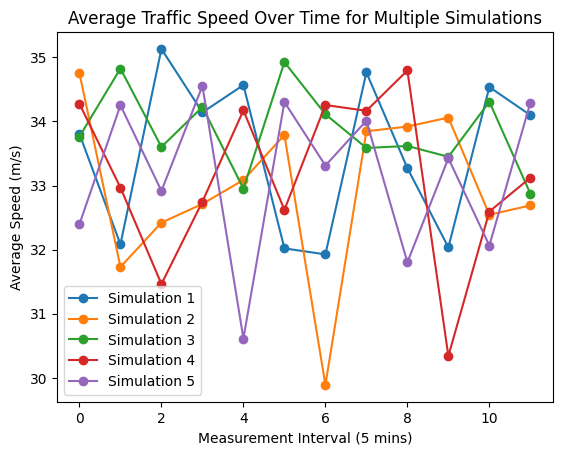

In [8]:
# Number of simulation runs
num_simulations = 5

# Store the results of each simulation
all_simulation_results = []

# Specify the network file based on the scenario you want to run
network_file = f"AH2174_2023_project1_section2.net.xml"

# Run multiple simulations with different random seeds
for run in range(num_simulations):
    # Choose a different random seed for each run
    random_seed = np.random.randint(1, 1000)
    # print(random_seed)

    # generate the arrival time that follows the poisson process
    arrival_rate = 3000/3600  # Arrival rate of 3000 vehicles per hour
    random_variable_size = 3000
    interarrival_times = [generate_interarrival_time(arrival_rate) for _ in range(random_variable_size)]

    # generate the new rou.xml
    vehicle2file()

    # Run the simulation for the current random seed
    simulation_results = run_simulation(network_file,random_seed)

    # Append the results to the list
    all_simulation_results.append(simulation_results)

# Plot the results for each simulation run
for i, simulation_results in enumerate(all_simulation_results):
    plt.plot(simulation_results, marker='o', linestyle='-', label=f'Simulation {i + 1}')

plt.title('Average Traffic Speed Over Time for Multiple Simulations')
plt.xlabel('Measurement Interval (5 mins)')
plt.ylabel('Average Speed (m/s)')
plt.legend()
plt.show()

In [9]:
all_simulation_results

[[33.80419441531259,
  32.083233236782945,
  35.132535535773115,
  34.14215178652005,
  34.5683796341579,
  32.020281631566654,
  31.926489091641002,
  34.76521170364409,
  33.27319843190938,
  32.03598833465644,
  34.537385721362284,
  34.09900037677154],
 [34.754963227703804,
  31.729435223871167,
  32.42174654501134,
  32.71376544110892,
  33.087356880699204,
  33.789438919703684,
  29.88937086093757,
  33.84742255073713,
  33.92089791839611,
  34.06117979102363,
  32.54457062348774,
  32.690094938083725],
 [33.76410133447538,
  34.82672651458425,
  33.602503386909675,
  34.2260047656782,
  32.95259451061271,
  34.92633666156948,
  34.11251742466393,
  33.5871462946477,
  33.618548103913355,
  33.44909358696935,
  34.30820893201282,
  32.87440250080577],
 [34.27652121960109,
  32.96894078386015,
  31.46361919562008,
  32.749859715026254,
  34.17357812584861,
  32.62170386216958,
  34.256867860257024,
  34.16680815364561,
  34.79610086475205,
  30.34020870022046,
  32.59474170466768,

## 2.3 Alternative scenario

To simulate the new scenario, we generate a new net.file (AH2174_2023_project1_Section2_alternativescenario.net.xml) by a new edge.xml (AH2174_2023_project1_Section2_alternativescenario.edge). Beacuse we assum that the warmup time is 600 seconds, the laneclosure time of the edge 4 should consider that. So in this new edge.xml, the closure begin time is set to 2400 (1800+600), and the end time is set to 4140 (3540+600).

netconvert --node-files AH2174_2023_project1_Section2.nod.xml --edge-files AH2174_2023_project1_Section2_alternativescenario.edge.xml -t AH2174_2023_project1_Section2.type.xml -o AH2174_2023_project1_Section2_alternativescenario.net.xml

In [84]:
traci.close()

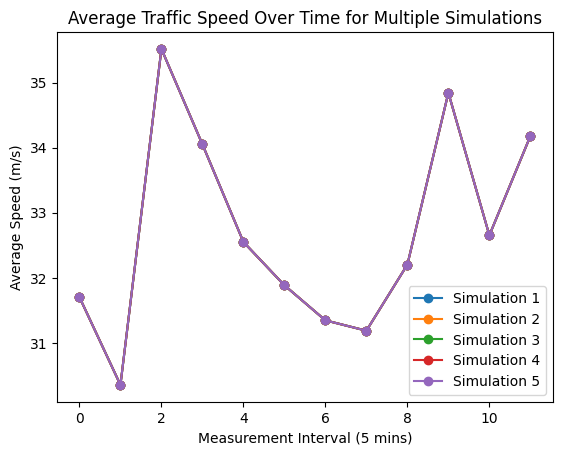

In [85]:
# Number of simulation runs
num_simulations = 5

# Store the results of each simulation
all_simulation_results_2 = []

# Specify the network file based on the scenario you want to run
network_file = f"AH2174_2023_project1_Section2_alternativescenario.net.xml"

# Run multiple simulations with different random seeds
for run in range(num_simulations):
    # Choose a different random seed for each run
    random_seed = np.random.randint(1, 1000)

    # Run the simulation for the current random seed
    simulation_results = run_simulation(network_file,random_seed)

    # Append the results to the list
    all_simulation_results_2.append(simulation_results)

# Plot the results for each simulation run
for i, simulation_results in enumerate(all_simulation_results_2):
    plt.plot(simulation_results, marker='o', linestyle='-', label=f'Simulation {i + 1}')

plt.title('Average Traffic Speed Over Time for Multiple Simulations')
plt.xlabel('Measurement Interval (5 mins)')
plt.ylabel('Average Speed (m/s)')
plt.legend()
plt.show()

In [86]:
all_simulation_results_2

[[31.703385007948942,
  30.354343554936396,
  35.517892942670464,
  34.051617801611876,
  32.55136455694316,
  31.885487817831805,
  31.346676125660444,
  31.187404658932135,
  32.20305799449149,
  34.84351875834325,
  32.65381707367096,
  34.17806274223144],
 [31.703385007948942,
  30.354343554936396,
  35.517892942670464,
  34.051617801611876,
  32.55136455694316,
  31.885487817831805,
  31.346676125660444,
  31.187404658932135,
  32.20305799449149,
  34.84351875834325,
  32.65381707367096,
  34.17806274223144],
 [31.703385007948942,
  30.354343554936396,
  35.517892942670464,
  34.051617801611876,
  32.55136455694316,
  31.885487817831805,
  31.346676125660444,
  31.187404658932135,
  32.20305799449149,
  34.84351875834325,
  32.65381707367096,
  34.17806274223144],
 [31.703385007948942,
  30.354343554936396,
  35.517892942670464,
  34.051617801611876,
  32.55136455694316,
  31.885487817831805,
  31.346676125660444,
  31.187404658932135,
  32.20305799449149,
  34.84351875834325,
  3